<a href="https://colab.research.google.com/github/SurangaPrasad/deep_learning/blob/main/transfer_learning_v1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***ResNet18 Model***

### Train validate and test using ***miniImageNet*** data set

In [1]:
## import python scrips from "https://github.com/SurangaPrasad/deep_learning.git"

import torch
import torchvision
from torch import nn
from torchvision import transforms

try:
    from modular import helper, dl_engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find modular scripts... downloading them from GitHub.")
    !git clone https://github.com/SurangaPrasad/deep_learning.git
    !mv deep_learning/modular/ .
    !rm -rf deep_learning
    from modular import helper, dl_engine

[INFO] Couldn't find modular scripts... downloading them from GitHub.
Cloning into 'deep_learning'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 109 (delta 51), reused 5 (delta 0), pack-reused 0
Receiving objects: 100% (109/109), 584.12 KiB | 5.84 MiB/s, done.
Resolving deltas: 100% (51/51), done.
The selected device is cuda


In [ ]:
#!rm -rf modular

In [2]:
## download and create the data loaders

import os
import gdown
from pathlib import Path

# set the device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"The selected device is {device}")

data_path = Path("data/")
image_path = data_path / "mini_image_net"

url = 'https://drive.usercontent.google.com/download?id=107FTosYIeBn5QbynR46YG91nHcJ70whs&export=download&authuser=0&confirm=t&uuid=60b63e1a-f494-4f24-bdb1-b55131562a39&at=APZUnTVF0wI3FBlvrHXL3r-PlZjg:1704103333738'

helper.download_and_extract(data_path, image_path, url,"mini_image_net.tar",False)

## geting the weight of pretrained model
weights = torchvision.models.ResNet18_Weights.DEFAULT

# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()

#Splitting data in to train, test and validation
originalDataset = torchvision.datasets.ImageFolder(image_path/ "train", transform = auto_transforms)

random_gen = torch.Generator().manual_seed(42)

test_data, train_data, val_data = torch.utils.data.random_split(originalDataset, [0.8, 0.1, 0.1] , generator=random_gen)
class_names = originalDataset.classes

# Create training, testing and validation DataLoaders
train_dataloader, test_dataloader,valid_dataloader = helper.create_dataloaders(train_data,
                                                                               test_data,
                                                                               val_data,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32



The selected device is cuda
Did not find data/mini_image_net directory, creating one...
Unzipping tar file...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 79.4MB/s]


epoch: 9, lr: 0.001000, accuracy: 0.883594, loss: 0.564501, valid accuracy: 0.729688
accuracy on testing data: 0.733496
[INFO] Total training time: 341.206 seconds


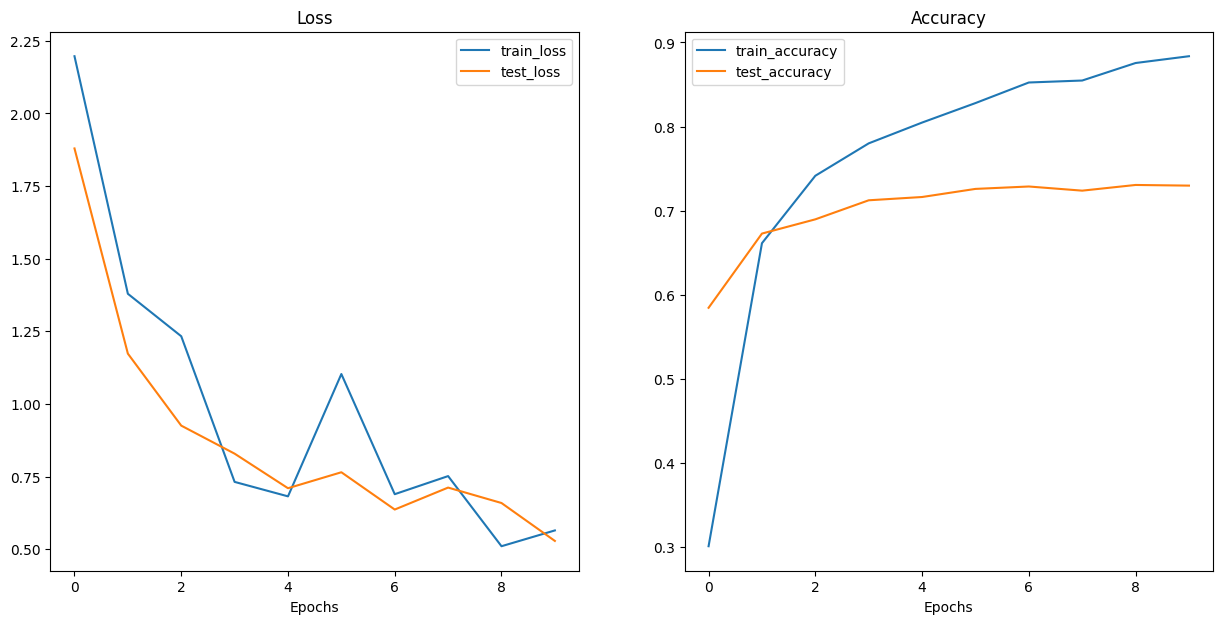

In [3]:
##train, validate and test model

##loading pretrained model
model_resnet_18 = torchvision.models.resnet18(weights, progress = True)

#Freezing parameters
for param in model_resnet_18.parameters():
    param.requires_grad = False

output_shape = len(originalDataset.classes)

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Recreate the fc layer and seed it to the target device
model_resnet_18.fc = torch.nn.Linear(in_features=512,
                                     out_features=output_shape, # same number of output units as our number of classes
                                     bias=True).to(device)

# Define loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet_18.parameters(), lr=0.001)



# Start the timer
from timeit import default_timer as timer
start_time = timer()
epoches = 10

train_val_results = dl_engine.train(model_resnet_18, train_dataloader, valid_dataloader, loss_function, optimizer, epoches)
acc_test,loss_test = dl_engine.eval(model_resnet_18, test_dataloader, loss_function)

print('accuracy on testing data: %f' % acc_test) #  a reference output is provided below:

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

helper.plot_loss_curves(train_val_results)

In [4]:
## Save the model

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "model_resnet_18.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_resnet_18.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/model_resnet_18.pth


### Finetuning using EuroSat data set

data/eurosat directory exists.
epoch: 9, lr: 0.001000, accuracy: 0.200000, loss: 3.178409, valid accuracy: 0.173333
epoch: 19, lr: 0.001000, accuracy: 0.560000, loss: 1.322882, valid accuracy: 0.293333
epoch: 29, lr: 0.001000, accuracy: 1.000000, loss: 0.676342, valid accuracy: 0.586667
epoch: 39, lr: 0.001000, accuracy: 1.000000, loss: 0.355743, valid accuracy: 0.680000
epoch: 9, lr: 0.001000, accuracy: 0.400000, loss: 7.886873, valid accuracy: 0.320000
epoch: 19, lr: 0.001000, accuracy: 0.440000, loss: 1.512266, valid accuracy: 0.413333
epoch: 29, lr: 0.001000, accuracy: 0.680000, loss: 1.058777, valid accuracy: 0.440000
epoch: 39, lr: 0.001000, accuracy: 1.000000, loss: 0.301800, valid accuracy: 0.680000
epoch: 9, lr: 0.001000, accuracy: 0.600000, loss: 2.565678, valid accuracy: 0.453333
epoch: 19, lr: 0.001000, accuracy: 0.720000, loss: 0.807003, valid accuracy: 0.413333
epoch: 29, lr: 0.001000, accuracy: 0.960000, loss: 0.353714, valid accuracy: 0.626667
epoch: 39, lr: 0.001000, a

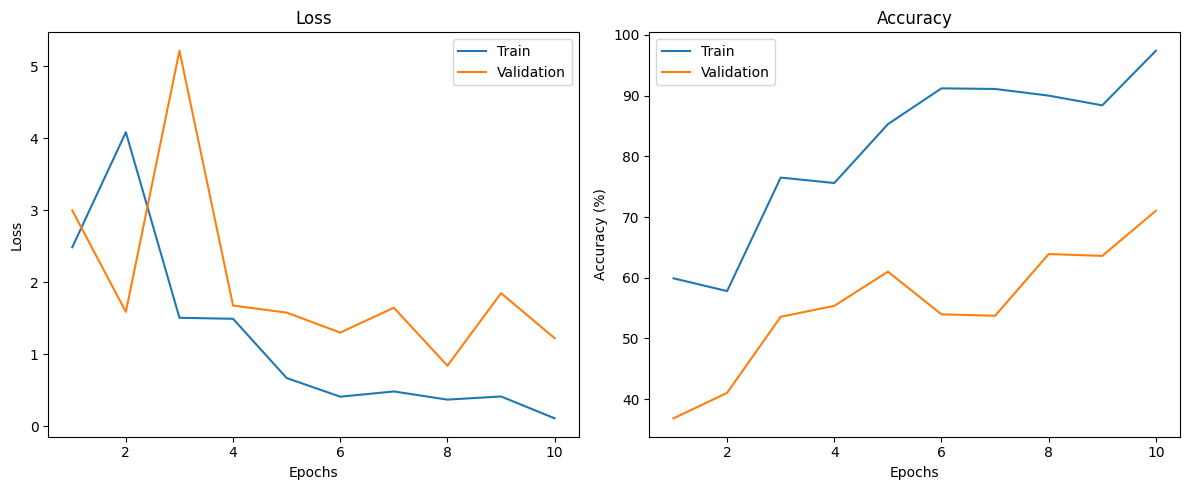

The average test accuracy is 0.5540334582328796
The average test loss is 1.989741563796997


In [8]:
#download and extract EuroSat data set

from pathlib import Path
data_path = Path("data/")
image_path = data_path / "eurosat"
url = "https://madm.dfki.de/files/sentinel/EuroSAT.zip"

helper.download_and_extract(data_path,image_path, url, "eurosat.zip")

eurosat_dataset = torchvision.datasets.ImageFolder(image_path / "2750")
output_shape2 = len(eurosat_dataset)

## Converting above training and testing data sets in to data loaders
import random
import numpy as np
import torchvision
import torch

data_path2 = Path("models/")
saved_path2 = data_path2 / "model_resnet_18.pth"

weights = torchvision.models.ResNet18_Weights.DEFAULT

loaded_model_resnet = torchvision.models.resnet18(weights, progress = True)

#Freezing parameters
for param in loaded_model_resnet.parameters():
    param.requires_grad = False

loaded_model_resnet.fc = torch.nn.Linear(in_features=512,
                                  out_features=output_shape, # same number of output units as our number of classes
                                  bias=True).to(device)

loaded_model_resnet.load_state_dict(torch.load(saved_path2))

# Recreate the fc layer according to data set
loaded_model_resnet.fc = torch.nn.Linear(in_features=512,
                                      out_features=output_shape2, # same number of output units as our number of classes
                                      bias=True).to(device)
optimizer = torch.optim.Adam(loaded_model_resnet.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()


average_results = {"train_loss": [],
                    "train_acc": [],
                    "val_loss": [],
                    "val_acc":[]
                  }

# Start the timer
from timeit import default_timer as timer
start_time = timer()
epoches = 40


for staring_number in range(0,10):

  train_loader_eurosat, test_loader_eurosat = helper.getEuroSatDataLoaders(staring_number, eurosat_dataset)
  train_val_results = dl_engine.train(loaded_model_resnet, train_loader_eurosat, test_loader_eurosat, loss_function, optimizer, epoches)

  average_results['train_loss'].append(sum(train_val_results['train_loss'])/epoches)
  average_results['train_acc'].append(sum(train_val_results['train_acc'])/epoches)
  average_results['val_loss'].append(sum(train_val_results['val_loss'])/epoches)
  average_results['val_acc'].append(sum(train_val_results['val_acc'])/epoches)

##creating a testing data loader and testing the model performance

staring_number = 30  # set the starting nnumber to 20 for collecting different test data set

train_loader_eurosat, test_loader_eurosat = helper.getEuroSatDataLoaders(staring_number, eurosat_dataset)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

helper.plot_average(average_results)

print(f"The average test accuracy is {sum(average_results['val_acc'])/len(average_results['val_acc'])}")
print(f"The average test loss is {sum(average_results['val_loss'])/len(average_results['val_loss'])}")


## ***VGG11 Model***

###Train validate and test using miniImageNet data set

In [9]:
## geting the weight of pretrained model
weights_vgg11 = torchvision.models.VGG11_Weights.IMAGENET1K_V1

# Get the transforms used to create our pretrained weights
auto_transforms = weights_vgg11.transforms()

data_path = Path("data/")
image_path = data_path / "mini_image_net"

#Splitting data in to train, test and validation
originalDataset = torchvision.datasets.ImageFolder(image_path/ "train", transform = auto_transforms)
random_gen = torch.Generator().manual_seed(42)

test_data, train_data, val_data = torch.utils.data.random_split(originalDataset, [0.8, 0.1, 0.1] , generator=random_gen)
class_names = originalDataset.classes

# Create training, testing and validation DataLoaders
train_dataloader, test_dataloader,valid_dataloader = helper.create_dataloaders(train_data,
                                                                               test_data,
                                                                               val_data,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:07<00:00, 75.0MB/s]


epoch: 9, lr: 0.001000, accuracy: 0.951042, loss: 0.127408, valid accuracy: 0.722135
accuracy on testing data: 0.732715
[INFO] Total training time: 377.657 seconds


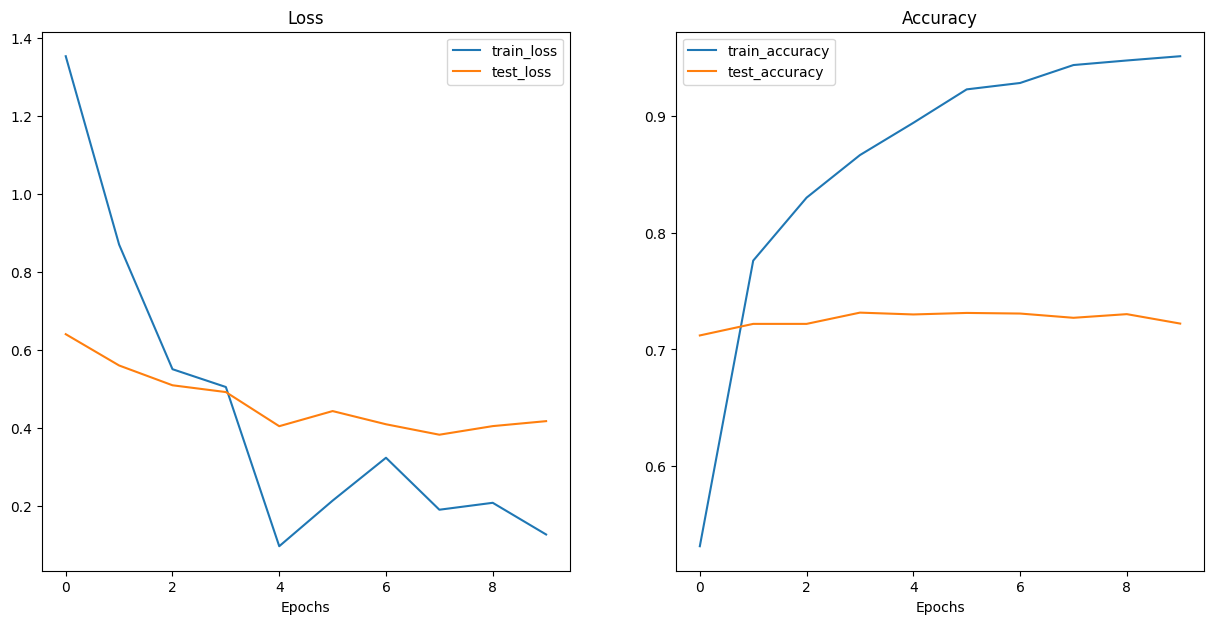

In [10]:
##train, validate and test model

##loading pretrained model
model_vgg_11 = torchvision.models.vgg11(weights_vgg11, progress = True)

#Freezing parameters
for param in model_vgg_11.parameters():
    param.requires_grad = False

output_shape = len(originalDataset.classes)

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Recreate the fc layer and seed it to the target device
model_vgg_11.classifier[-1] = torch.nn.Linear(in_features=4096,  # Assuming the default in_features for VGG16
                                              out_features=output_shape,
                                              bias=True).to(device)

# Define loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_vgg_11.parameters(), lr=0.001)



# Start the timer
from timeit import default_timer as timer
start_time = timer()
epoches = 10

train_val_results = dl_engine.train(model_vgg_11, train_dataloader, valid_dataloader, loss_function, optimizer, epoches)
acc_test,loss_test = dl_engine.eval(model_vgg_11, test_dataloader, loss_function)

print('accuracy on testing data: %f' % acc_test) #  a reference output is provided below:

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")
helper.plot_loss_curves(train_val_results)

In [11]:
## Save the model

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "model_vgg_11.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_vgg_11.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/model_vgg_11.pth


##Finetuning using EuroSat data set

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


epoch: 9, lr: 0.001000, accuracy: 0.840000, loss: 0.767808, valid accuracy: 0.653333
epoch: 19, lr: 0.001000, accuracy: 0.920000, loss: 0.436002, valid accuracy: 0.693333
epoch: 29, lr: 0.001000, accuracy: 1.000000, loss: 0.289570, valid accuracy: 0.693333
epoch: 39, lr: 0.001000, accuracy: 0.880000, loss: 0.286107, valid accuracy: 0.720000
epoch: 9, lr: 0.001000, accuracy: 0.680000, loss: 0.835913, valid accuracy: 0.560000
epoch: 19, lr: 0.001000, accuracy: 0.840000, loss: 0.411640, valid accuracy: 0.560000
epoch: 29, lr: 0.001000, accuracy: 0.960000, loss: 0.132302, valid accuracy: 0.666667
epoch: 39, lr: 0.001000, accuracy: 1.000000, loss: 0.053991, valid accuracy: 0.733333
epoch: 9, lr: 0.001000, accuracy: 0.880000, loss: 0.566710, valid accuracy: 0.720000
epoch: 19, lr: 0.001000, accuracy: 0.880000, loss: 0.369378, valid accuracy: 0.746667
epoch: 29, lr: 0.001000, accuracy: 0.960000, loss: 0.147708, valid accuracy: 0.760000
epoch: 39, lr: 0.001000, accuracy: 1.000000, loss: 0.1489

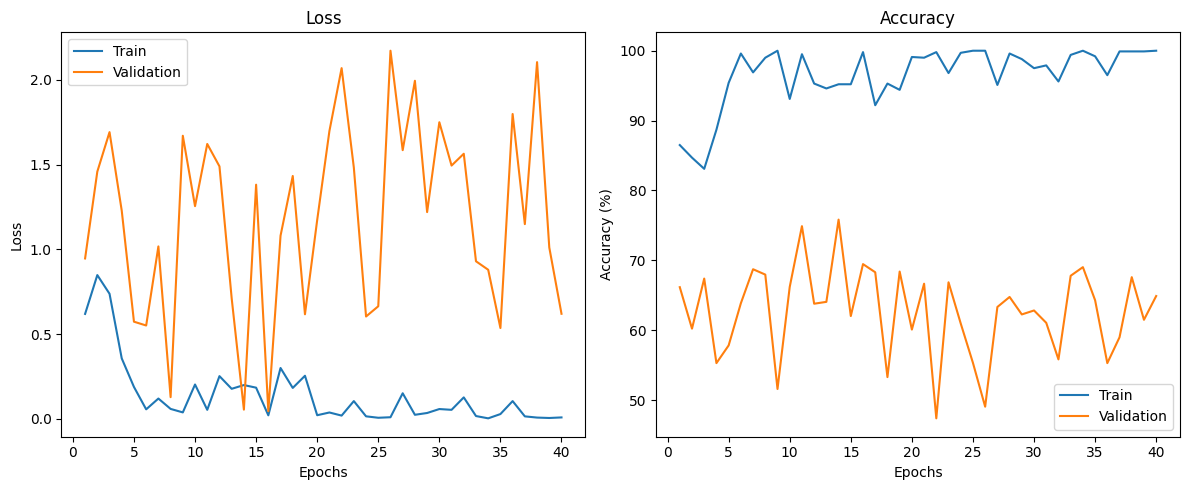

The average test accuracy is 0.627833366394043
The average test loss is 1.1861598491668701


In [12]:
image_path = data_path / "eurosat"
eurosat_dataset = torchvision.datasets.ImageFolder(image_path / "2750")
output_shape = 5

## Converting above training and testing data sets in to data loaders
import random
import numpy as np
import torchvision
import torch


## import the saved model


data_path2 = Path("models/")
saved_path2 = data_path2 / "model_vgg_11.pth"
weights_vgg = torchvision.models.VGG11_Weights.IMAGENET1K_V1

##load model
loaded_model_vgg11 = torchvision.models.vgg11(weights_vgg, progress = True)


#Freezing parameters
for param in loaded_model_vgg11.parameters():
    param.requires_grad = False

#Unfreez layer 4 and last layer

for param in loaded_model_vgg11.classifier.parameters():
    param.requires_grad = True

output_shape = len(originalDataset.classes)

loaded_model_vgg11.classifier[-1] = torch.nn.Linear(in_features=4096,  # Assuming the default in_features for VGG16
                                              out_features=output_shape,
                                              bias=True).to(device)

loaded_model_vgg11.load_state_dict(torch.load(saved_path2))



# Start the timer
from timeit import default_timer as timer
start_time = timer()
epoches = 40

output_shape2 = len(eurosat_dataset.classes)

# Recreate the fc layer and seed it to the target device
model_vgg_11.classifier[-1] = torch.nn.Linear(in_features=4096,  # Assuming the default in_features for VGG16
                                              out_features=output_shape2,
                                              bias=True).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_vgg_11.parameters(), lr=0.001)

average_results = {"train_loss": [],
                    "train_acc": [],
                    "val_loss": [],
                    "val_acc":[]
                  }

for staring_number in range(0,40):

  train_loader_eurosat, test_loader_eurosat = helper.getEuroSatDataLoaders(staring_number, eurosat_dataset)
  train_val_results = dl_engine.train(model_vgg_11, train_loader_eurosat, test_loader_eurosat, loss_function, optimizer, epoches)

  average_results['train_loss'].append(sum(train_val_results['train_loss'])/epoches)
  average_results['train_acc'].append(sum(train_val_results['train_acc'])/epoches)
  average_results['val_loss'].append(sum(train_val_results['val_loss'])/epoches)
  average_results['val_acc'].append(sum(train_val_results['val_acc'])/epoches)

##creating a testing data loader and testing the model performance

staring_number = 30  # set the starting nnumber to 20 for collecting different test data set

train_loader_eurosat, test_loader_eurosat = helper.getEuroSatDataLoaders(staring_number, eurosat_dataset)
acc_test,loss_test = dl_engine.eval(model_vgg_11, test_loader_eurosat, loss_function)

print('accuracy on testing data: %f' % acc_test) #  a reference output is provided below:

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")



helper.plot_average(average_results)

print(f"The average test accuracy is {sum(average_results['val_acc'])/len(average_results['val_acc'])}")
print(f"The average test loss is {sum(average_results['val_loss'])/len(average_results['val_loss'])}")


## ***VIT_B_16 Model***

###Train validate and test using miniImageNet data set

In [13]:
## geting the weight of pretrained model
weights_vit_b_16 = torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1

# Get the transforms used to create our pretrained weights
auto_transforms = weights_vit_b_16.transforms()

data_path = Path("data/")
image_path = data_path / "mini_image_net"

#Splitting data in to train, test and validation
originalDataset = torchvision.datasets.ImageFolder(image_path/ "train", transform = auto_transforms)
random_gen = torch.Generator().manual_seed(42)

test_data, train_data, val_data = torch.utils.data.random_split(originalDataset, [0.8, 0.1, 0.1] , generator=random_gen)
class_names = originalDataset.classes

# Create training, testing and validation DataLoaders
train_dataloader, test_dataloader,valid_dataloader = helper.create_dataloaders(train_data,
                                                                               test_data,
                                                                               val_data,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:08<00:00, 39.6MB/s]


epoch: 9, lr: 0.001000, accuracy: 1.000000, loss: 0.017060, valid accuracy: 0.928906
accuracy on testing data: 0.929948
[INFO] Total training time: 1381.027 seconds


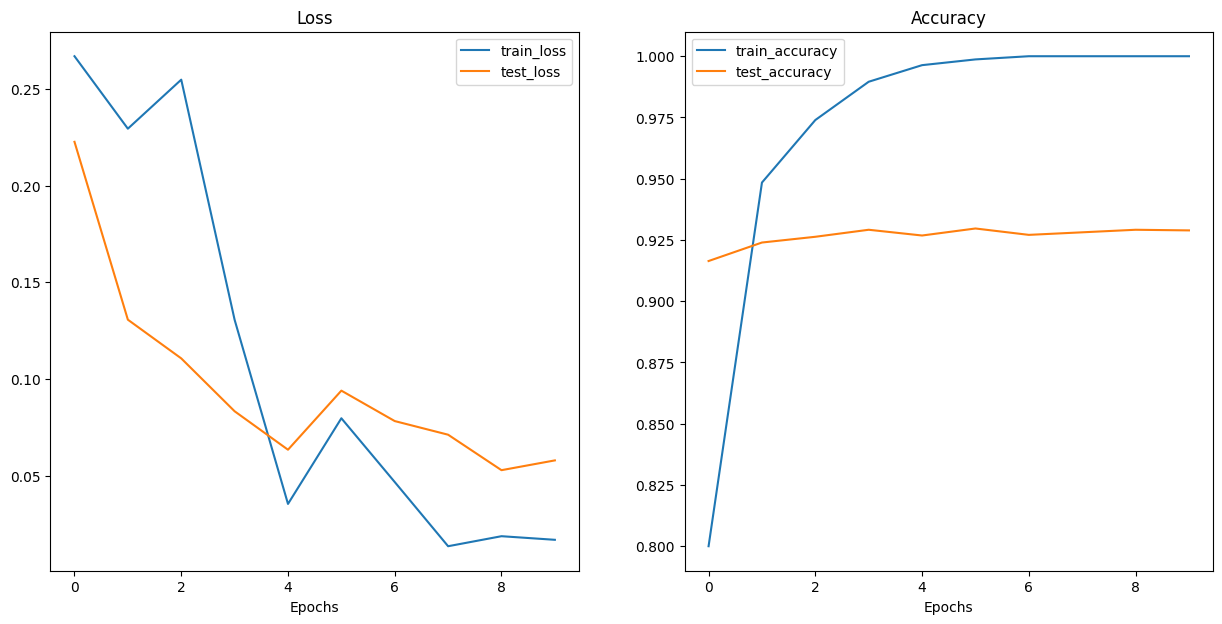

In [14]:
##train, validate and test model

##loading pretrained model
model_vit_b_16 = torchvision.models.vit_b_16(weights_vit_b_16, progress = True)

#Freezing parameters
for param in model_vit_b_16.parameters():
    param.requires_grad = False

output_shape = len(originalDataset.classes)

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)


model_vit_b_16.heads = torch.nn.Linear(in_features=768,
                                       out_features=output_shape, # same number of output units as our number of classes
                                       bias=True).to(device)

# Define loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_vit_b_16.parameters(), lr=0.001)



# Start the timer
from timeit import default_timer as timer
start_time = timer()
epoches = 10

train_val_results = dl_engine.train(model_vit_b_16, train_dataloader, valid_dataloader, loss_function, optimizer, epoches)
acc_test,loss_test = dl_engine.eval(model_vit_b_16, test_dataloader, loss_function)

print('accuracy on testing data: %f' % acc_test) #  a reference output is provided below:

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")
helper.plot_loss_curves(train_val_results)

In [15]:
## Save the model

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "model_vit_b_16.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_vit_b_16.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/model_vit_b_16.pth


###Finetuning using EuroSat data set

epoch: 9, lr: 0.001000, accuracy: 1.000000, loss: 0.811890, valid accuracy: 0.733333
epoch: 19, lr: 0.001000, accuracy: 1.000000, loss: 0.298461, valid accuracy: 0.826667
epoch: 29, lr: 0.001000, accuracy: 1.000000, loss: 0.137145, valid accuracy: 0.826667
epoch: 39, lr: 0.001000, accuracy: 1.000000, loss: 0.079600, valid accuracy: 0.826667
epoch: 9, lr: 0.001000, accuracy: 0.400000, loss: 1.415669, valid accuracy: 0.346667
epoch: 19, lr: 0.001000, accuracy: 0.920000, loss: 0.360843, valid accuracy: 0.586667
epoch: 29, lr: 0.001000, accuracy: 0.960000, loss: 0.136772, valid accuracy: 0.720000
epoch: 39, lr: 0.001000, accuracy: 1.000000, loss: 0.056116, valid accuracy: 0.733333
epoch: 9, lr: 0.001000, accuracy: 0.880000, loss: 0.455874, valid accuracy: 0.453333
epoch: 19, lr: 0.001000, accuracy: 0.960000, loss: 0.250418, valid accuracy: 0.520000
epoch: 29, lr: 0.001000, accuracy: 1.000000, loss: 0.117687, valid accuracy: 0.573333
epoch: 39, lr: 0.001000, accuracy: 1.000000, loss: 0.0723

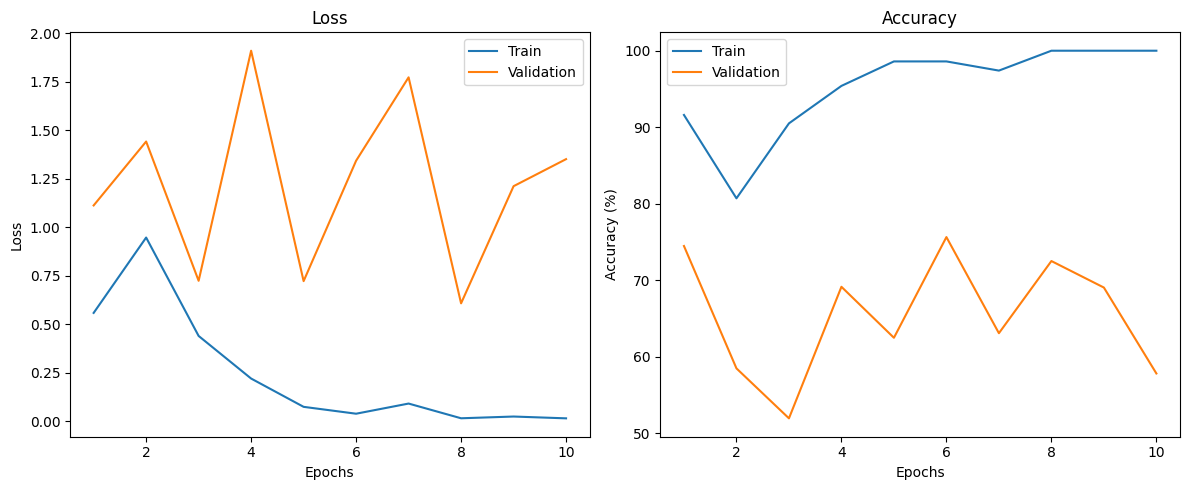

The average test accuracy is 0.6545000672340393
The average test loss is 1.2187923192977905


In [21]:
image_path = data_path / "eurosat"
eurosat_dataset = torchvision.datasets.ImageFolder(image_path / "2750")

## Converting above training and testing data sets in to data loaders
import random
import numpy as np
import torchvision
import torch

##load the saved model

data_path2 = Path("models/")
weights_vit = torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1

##load model
loaded_model_vit = torchvision.models.vit_b_16(weights_vit, progress = True)


#Freezing parameters
for param in loaded_model_vit.parameters():
    param.requires_grad = False


output_shape = len(originalDataset.classes)

loaded_model_vit.heads = torch.nn.Linear(in_features=768,
                                       out_features=output_shape, # same number of output units as our number of classes
                                       bias=True).to(device)

saved_path2 = data_path2 / "model_vit_b_16.pth"
loaded_model_vit.load_state_dict(torch.load(saved_path2))



# Start the timer
from timeit import default_timer as timer
start_time = timer()
epoches = 40

output_shape2 = len(eurosat_dataset.classes)
loaded_model_vit.heads = torch.nn.Linear(in_features=768,
                                       out_features=output_shape2, # same number of output units as our number of classes
                                       bias=True).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(loaded_model_vit.parameters(), lr=0.001)

average_results = {"train_loss": [],
                    "train_acc": [],
                    "val_loss": [],
                    "val_acc":[]
                  }

for staring_number in range(0,10):
  train_loader_eurosat, test_loader_eurosat = helper.getEuroSatDataLoaders(staring_number, eurosat_dataset)
  train_val_results = dl_engine.train(loaded_model_vit, train_loader_eurosat, test_loader_eurosat, loss_function, optimizer, epoches)

  average_results['train_loss'].append(sum(train_val_results['train_loss'])/epoches)
  average_results['train_acc'].append(sum(train_val_results['train_acc'])/epoches)
  average_results['val_loss'].append(sum(train_val_results['val_loss'])/epoches)
  average_results['val_acc'].append(sum(train_val_results['val_acc'])/epoches)

##creating a testing data loader and testing the model performance

staring_number = 30  # set the starting nnumber to 20 for collecting different test data set

train_loader_eurosat, test_loader_eurosat = helper.getEuroSatDataLoaders(staring_number, eurosat_dataset)
acc_test,loss_test = dl_engine.eval(loaded_model_vit, test_loader_eurosat, loss_function)

print('accuracy on testing data: %f' % acc_test) #  a reference output is provided below:

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

helper.plot_average(average_results)

print(f"The average test accuracy is {sum(average_results['val_acc'])/len(average_results['val_acc'])}")
print(f"The average test loss is {sum(average_results['val_loss'])/len(average_results['val_loss'])}")